## Machine Learning
### Fonte: Aula 03, prática 4 ( Recursos Avançados Aplicados ao Aprendizado Supervisionado)


In [349]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Carga do Dataset

In [133]:
# Informa a URL de importação do dataset
#url = "https://raw.githubusercontent.com/tatianaesc/datascience/main/diabetes.csv"
url = "c:/pos/MVP1/atrasos_tratados.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,Quantidade,DiaDaSemana,Turno,TipoFrete,TipoTransporte,OrdemViagem,PercAtraso,Atraso
0,6,5,3,0,3,1,0.2,0
1,6,5,3,0,3,1,0.1,0
2,6,6,3,0,3,1,0.1,0
3,6,5,3,0,3,1,0.2,0
4,6,5,3,0,3,1,0.0,0


## Separação em conjunto de treino e conjunto de teste com holdout

In [330]:
array = dataset.values
numCols = len(dataset.columns)
X = array[:,0:numCols-1]
y = array[:,numCols-1].astype(int)
# exibe informações do dataset
dataset.info()
# imprime as primeira linha do array X e o vetor y
print("Primeiras 5 linhas do vetor X")
print(X[0:5])
print("Primeiras 5 linhas do vetor y")
print(y)
# Verifica a distribuição das classes
print("Distribuição das classes")
print(dataset.groupby('Atraso').size())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22807 entries, 0 to 22806
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Quantidade      22807 non-null  int64  
 1   DiaDaSemana     22807 non-null  int64  
 2   Turno           22807 non-null  int64  
 3   TipoFrete       22807 non-null  int64  
 4   TipoTransporte  22807 non-null  int64  
 5   OrdemViagem     22807 non-null  int64  
 6   PercAtraso      22807 non-null  float64
 7   Atraso          22807 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 1.4 MB
Primeiras 5 linhas do vetor X
[[6.  5.  3.  0.  3.  1.  0.2]
 [6.  5.  3.  0.  3.  1.  0.1]
 [6.  6.  3.  0.  3.  1.  0.1]
 [6.  5.  3.  0.  3.  1.  0.2]
 [6.  5.  3.  0.  3.  1.  0. ]]
Primeiras 5 linhas do vetor y
[0 0 0 ... 0 0 0]
Distribuição das classes
Atraso
0    21036
1     1771
dtype: int64


In [392]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:numCols-1]
y = array[:,numCols-1]
# Retirei o parâmetro stratify=y para evitar o erro 'The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.'
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
#scoring = 'accuracy'
# O dataset está desbalanceado. Para tratar esse problema, será utilizado o parâmetro class_weight='balanced' em alguns modelos do modelo LogisticRegression.
# É importante minimizar o falso positivo (classe 0 previsto como classe 1)
# A métrica para minimizar o falso positivo é o recall da classe minoritária (classe 1)
scoring = 'precision' # métrica para lidar com datasets desbalanceados
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

In [356]:
# Definindo uma semente global. Necessário para garantir reprodutibilidade dos resultados, 
# Faz com que os mesmos números aleatórios sejam gerados em todas as execuções.
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression()
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: 0.507643 (0.014757)
KNN: 0.491778 (0.011058)
CART: 0.544497 (0.010784)
NB: 0.563485 (0.011346)
SVM: 0.479799 (0.000064)


KeyboardInterrupt: 

### Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.514 (0.008)
KNN-orig: 0.504 (0.006)
CART-orig: 0.539 (0.009)
NB-orig: 0.549 (0.008)
SVM-orig: 0.500 (0.000)
Bag-orig: 0.537 (0.010)
RF-orig: 0.540 (0.009)
ET-orig: 0.543 (0.014)
Ada-orig: 0.506 (0.004)
GB-orig: 0.514 (0.007)
Vot-orig: 0.509 (0.005)
LR-padr: 0.514 (0.008)
KNN-padr: 0.526 (0.008)
CART-padr: 0.540 (0.007)
NB-padr: 0.549 (0.008)
SVM-padr: 0.511 (0.006)
Bag-padr: 0.536 (0.010)
RF-padr: 0.540 (0.008)
ET-padr: 0.542 (0.013)
Ada-padr: 0.506 (0.004)
GB-padr: 0.514 (0.007)
Vot-padr: 0.511 (0.006)
LR-norm: 0.514 (0.008)
KNN-norm: 0.524 (0.008)
CART-norm: 0.543 (0.008)
NB-norm: 0.549 (0.008)
SVM-norm: 0.506 (0.005)
Bag-norm: 0.539 (0.009)
RF-norm: 0.540 (0.007)
ET-norm: 0.542 (0.013)
Ada-norm: 0.506 (0.004)
GB-norm: 0.514 (0.007)
Vot-norm: 0.509 (0.005)


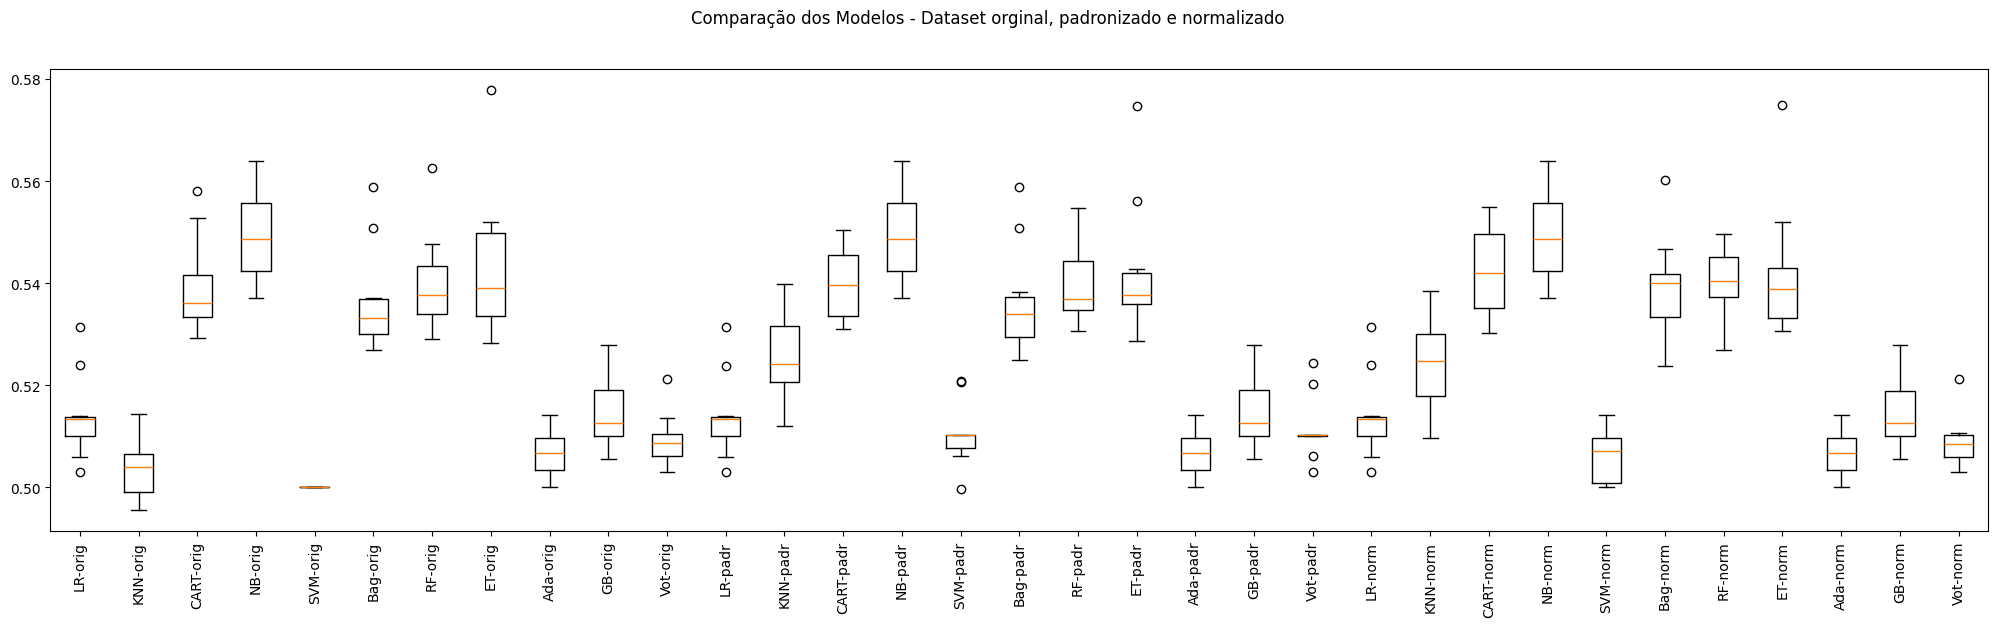

In [198]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
#pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
#pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'average'

In [393]:
# Tuning do Logistic Regression

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
log_reg = ('LogisticRegression', LogisticRegression())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('log_reg-orig', Pipeline(steps=[log_reg])))
#pipelines.append(('log_reg-padr', Pipeline(steps=[standard_scaler, log_reg])))
#pipelines.append(('log_reg-norm', Pipeline(steps=[min_max_scaler, log_reg])))

param_grid = {
    'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10],
    'LogisticRegression__penalty': ['l1', 'l2'],
    'LogisticRegression__solver': ['flbfgs','liblinear'],
    'LogisticRegression__max_iter': [100, 200],
    #'LogisticRegression__class_weight': [None, 'balanced'],    
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: log_reg-orig - Melhor: 0.750000 usando {'LogisticRegression__C': 0.1, 'LogisticRegression__max_iter': 100, 'LogisticRegression__penalty': 'l2', 'LogisticRegression__solver': 'liblinear'}


In [ ]:
# Tuning do Naive bayes

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
nb = ('NB', GaussianNB())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('nb-orig', Pipeline(steps=[nb])))
#pipelines.append(('nb-padr', Pipeline(steps=[standard_scaler, nb])))
#pipelines.append(('nb-norm', Pipeline(steps=[min_max_scaler, nb])))

param_grid = {
    'NB__var_smoothing': np.logspace(0,-9, num=100)
    
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: nb-orig - Melhor: 0.853359 usando {'NB__var_smoothing': np.float64(1.873817422860383e-05)}


## Finalização do Modelo

In [ ]:
# Tuning do Extra Trees

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
ET = ('ET', ExtraTreesClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('ET-orig', Pipeline(steps=[ET])))
#pipelines.append(('nb-padr', Pipeline(steps=[standard_scaler, nb])))
#pipelines.append(('nb-norm', Pipeline(steps=[min_max_scaler, nb])))

param_grid = {
    'ET__n_estimators': [50, 100, 200],
    'ET__max_features': [1, 2, 3],
    'ET__min_samples_split': [2, 5, 10]    
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: ET-orig - Melhor: 0.699112 usando {'ET__max_features': 1, 'ET__min_samples_split': 10, 'ET__n_estimators': 50}


In [ ]:
# Tuning do Gradient Boosting

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
GB = ('GB', GradientBoostingClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('GB-orig', Pipeline(steps=[GB])))
#pipelines.append(('nb-padr', Pipeline(steps=[standard_scaler, nb])))
#pipelines.append(('nb-norm', Pipeline(steps=[min_max_scaler, nb])))

param_grid = {
    'GB__n_estimators': [50, 100, 200],
    'GB__max_features': [1, 2, 3],
    'GB__min_samples_split': [2, 5, 10]    
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: GB-orig - Melhor: 0.865068 usando {'GB__max_features': 1, 'GB__min_samples_split': 10, 'GB__n_estimators': 50}


In [ ]:
# Tuning do Ada Boosting

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
AD = ('AD', AdaBoostClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('AD-orig', Pipeline(steps=[AD])))
#pipelines.append(('nb-padr', Pipeline(steps=[standard_scaler, nb])))
#pipelines.append(('nb-norm', Pipeline(steps=[min_max_scaler, nb])))

param_grid = {
    'AD__n_estimators': [50, 100, 200],
    'AD__learning_rate': [0.01, 0.1, 1.0]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: AD-orig - Melhor: 0.794948 usando {'AD__learning_rate': 1.0, 'AD__n_estimators': 100}


In [394]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
#scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
#rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=100,C=0.1,penalty='l2',solver='liblinear',class_weight='balanced')
#model = GaussianNB(var_smoothing=np.float64(1.873817422860383e-05))
#model = KNeighborsClassifier(metric='euclidean', n_neighbors=11)
#model = ExtraTreesClassifier(n_estimators=50, max_features=1, min_samples_split=10)
#model = GradientBoostingClassifier(n_estimators=50, max_features=1, min_samples_split=10)
#model = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)
#model.fit(rescaledX, y_train)
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste
#rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(X_test)
print("accuracy: " + str(accuracy_score(y_test, predictions)))
#print("precision: " + str(precision_score(y_test, predictions,average='weighted')))
print("precision: " + str(precision_score(y_test, predictions,average='binary', pos_label=1)))
print("recall: " + str(recall_score(y_test, predictions,average='binary', pos_label=1)))
print("f1: " + str(f1_score(y_test, predictions,average='binary', pos_label=1)))

# Exibe a matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test, predictions))


accuracy: 0.6850065760631302
precision: 0.14814814814814814
recall: 0.6440677966101694
f1: 0.24088748019017434
Matriz de confusão:
[[2897 1311]
 [ 126  228]]


In [395]:
# Preparação do modelo com TODO o dataset
#scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
#rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


## Simulando a aplicação do modelo em dados não vistos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Quantidade      4398 non-null   int64  
 1   DiaDaSemana     4398 non-null   int64  
 2   Turno           4398 non-null   int64  
 3   TipoFrete       4398 non-null   int64  
 4   TipoTransporte  4398 non-null   int64  
 5   OrdemViagem     4398 non-null   int64  
 6   PercAtraso      4398 non-null   float64
 7   Atraso          4398 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 275.0 KB
None
Distribuição das classes
Atraso
0    3939
1     459
dtype: int64
[[6.  2.  3.  0.  3.  1.  0.1 0. ]
 [6.  3.  3.  0.  3.  1.  0.1 0. ]
 [6.  2.  3.  0.  3.  1.  0.1 0. ]
 [6.  2.  3.  0.  3.  1.  0.1 0. ]
 [6.  2.  3.  0.  3.  1.  0.  0. ]]
y_test:      [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
predictions: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
accuracy: 0.7712596634834016
precisi

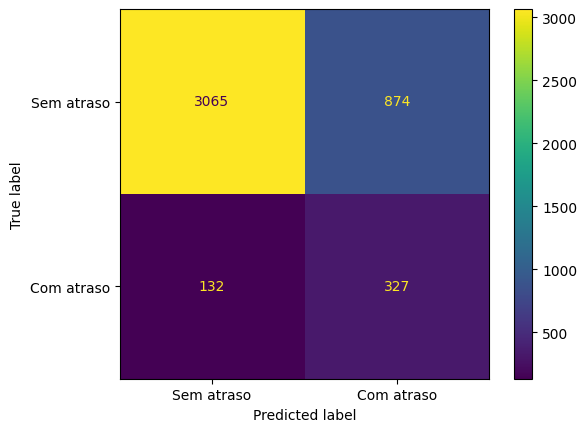


Relatório de Classificação:
              precision    recall  f1-score   support

  Sem atraso       0.96      0.78      0.86      3939
  Com atraso       0.27      0.71      0.39       459

    accuracy                           0.77      4398
   macro avg       0.62      0.75      0.63      4398
weighted avg       0.89      0.77      0.81      4398



In [396]:
# Teste com novos dados - julho/2025
# Lê o arquivo
datasetTest = pd.read_csv("c:/pos/MVP1/atrasos_junho_tratados.csv", delimiter=',')
print(datasetTest.info())

print("Distribuição das classes")
print(datasetTest.groupby('Atraso').size())

array = datasetTest.values
#array = array[array[:,numCols-1] == 0] # Varre o data dataset e cria um array somente com as linhas cuja coluna 7 sejam maiores que 0
print(array[0:5])

X_test = array[:,0:numCols-1]
y_test = array[:,numCols-1].astype(int)
predictions = model.predict(X_test).astype(int)

print("y_test:      " + str(y_test[0:20]) )
print("predictions: " + str(predictions[0:20]))

print("accuracy: " + str(accuracy_score(y_test, predictions)))
print("precision: " + str(precision_score(y_test, predictions)))
print("recall: " + str(recall_score(y_test, predictions)))
print("f1: " + str(f1_score(y_test, predictions)))

# Exibe a matriz de confusão
print("Matriz de confusão:")
cm=confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem atraso', 'Com atraso'])
disp.plot()
plt.show()

print()
# Exibe o relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, predictions, target_names=['Sem atraso', 'Com atraso']))

In [ ]:
# Novos dados
data = {'Quantidade':  [1, 3, 6, 4],
        'DiaDaSemana': [0, 1, 2, 4],
        'Turno': [0, 1, 3, 3],
        'TipoFrete': [0, 0, 1, 1],
        'TipoTransporte': [1, 1, 1, 1],
        'OrdemViagem': [1, 2, 1, 1],
        'PercAtraso': [0.0, 0.2, 0.2, 0]
        }

atributos = ['Quantidade', 'DiaDaSemana', 'Turno', 'TipoFrete', 'TipoTransporte', 'OrdemViagem', 'PercAtraso']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:numCols-1].astype(float)
X_entrada = [[6.,  2.,  3.,  0.,  3.,  1.,  0.5 ]]

print("Novos dados:")
print(X_entrada)
# Padronização nos dados de entrada usando o scaler utilizado em X
#rescaledEntradaX = scaler.transform(X_entrada)
#print(rescaledEntradaX)

# Predição de classes dos dados de entrada
print("Predições para os novos dados:")
saidas = model.predict(X_entrada)
print(saidas)

Novos dados:
[[6.0, 2.0, 3.0, 0.0, 3.0, 1.0, 0.5]]
Predições para os novos dados:
[1.]
